In [53]:
import numpy as np
import time as tm
import datetime as dt
import tensorflow as tf

# Data preparation
from yahoo_fin import stock_info as yf
from sklearn.preprocessing import MinMaxScaler
from collections import deque

# AI
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

# Graphics library
import matplotlib.pyplot as plt

In [54]:

# SETTINGS

# Window size or the sequence length, 7 (1 week)
N_STEPS = 30
FEATURES = ['open', 'high', 'low', 'close', 'volume']

# Lookup steps, 1 is the next day, 3 = after tomorrow
# LOOKUP_STEPS = [1, 2, 3]

# Stock ticker, GOOGL
STOCK = 'GOOGL'

# Current date
date_now = tm.strftime('%Y-%m-%d')
date_3_years_back = (dt.date.today() - dt.timedelta(days=1104)).strftime('%Y-%m-%d')

In [55]:
# LOAD DATA 
# from yahoo_fin 
# for 1104 bars with interval = 1d (one day)
init_df = yf.get_data(
    STOCK, 
    start_date=date_3_years_back, 
    end_date=date_now, 
    interval='1d')

In [57]:

# remove columns which our neural network will not use
init_df = init_df.drop(['adjclose', 'ticker'], axis=1)
# create the column 'date' based on index column
init_df['date'] = init_df.index

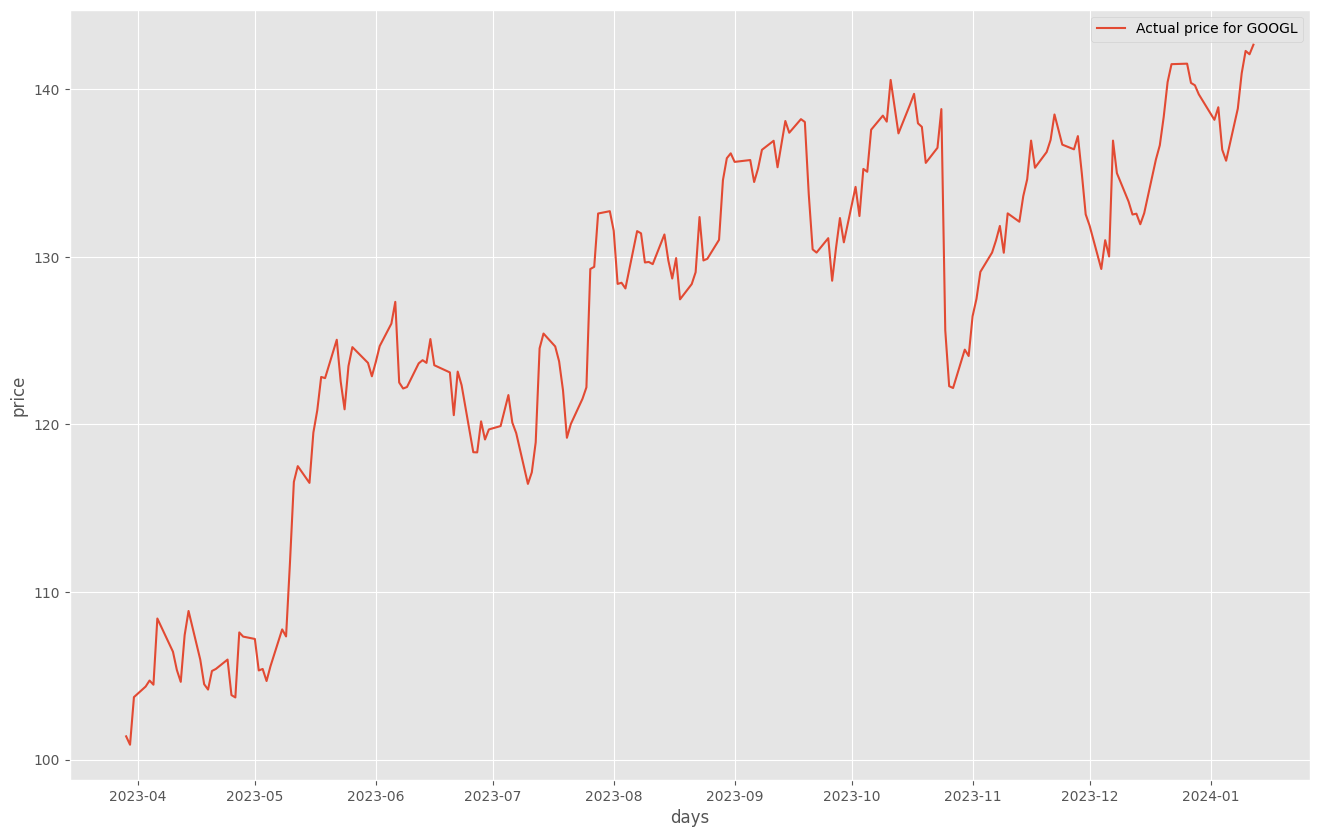

In [58]:
# NON-ESSENTIAL
# Let's preliminary see our data on the graphic
plt.style.use(style='ggplot')
plt.figure(figsize=(16,10))
plt.plot(init_df['close'][-200:])
plt.xlabel("days")
plt.ylabel("price")
plt.legend([f'Actual price for {STOCK}'])
plt.show()

In [ ]:

# Scale data for ML engine
# scaler = MinMaxScaler()
# # init_df['close'] = scaler.fit_transform(np.expand_dims(init_df['close'].values, axis=1))
# init_df[FEATURES] = scaler.fit_transform(
# 	init_df[FEATURES])
# init_df

In [116]:

def PrepareData():
  df = init_df.copy()
  # print(df)
  # df['future_close'] = df['close'].shift(-1)
  
  max_increase = df['high'].shift(-5).rolling(
    window=5,
    min_periods=5,
    closed='both').max()
  
  max_drawdown = df['low'].shift(-5).rolling(
		window=5,
		min_periods=5,
		closed='both').max()

  max_ratio_increase = (max_increase - df['close']) / df['close']
  max_ratio_drawdown = (max_drawdown - df['close']) / df['close']

  df['max_ratio_increase'] = max_ratio_increase
  df['max_ratio_drawdown'] = max_ratio_drawdown
  
  df.dropna(inplace=True)
  
  df['return_on_5_day_2_percent_hold'] = df['max_ratio_increase'].apply(lambda x: 1.02 if x > 0.02 else df['max_ratio_drawdown'])
  
  df.dropna(inplace=True)
  

  df['should_have_entered_5_day_2_percent_hold'] = df['return_on_5_day_2_percent_hold'].apply(lambda x: 1 if x == 1.02 else 0)


  WINDOW_SIZE = 30

  X = []
  Y = []

  for i in range(WINDOW_SIZE, len(df)):
    X.append(df[FEATURES].iloc[i-WINDOW_SIZE:i].values)
    Y.append(df['should_have_entered_5_day_2_percent_hold'].iloc[i])

  X = np.array(X)
  Y = np.array(Y)

  ## last_sequence = np.array(df[FEATURES].tail(1))
  
	# Remove the last couple of arrays, for which return analysis is impossible
  # sequence_data = []
  # sequences = deque(maxlen=N_STEPS)
  
  # print(df)

  # for entry, target in zip(df[FEATURES].values, df['should_have_entered_1_day_2_percent_hold'].values):
  #     print(entry, target)
  #     # sequences.append(entry)
  #     # if len(sequences) == N_STEPS:
  #     #     sequence_data.append([np.array(sequences), target])

  # last_sequence = list([s[:len(FEATURES)] for s in sequences]) + list(last_sequence)
  # last_sequence = np.array(last_sequence).astype(np.float32)

  # # construct the X's and Y's
  # X, Y = [], []
  # for seq, target in sequence_data:
  #     X.append(seq)
  #     Y.append(target)

  # # convert to numpy arrays
  # X = np.array(X)
  # Y = np.array(Y)

  return df, X, Y
  # return df, last_sequence, X, Y

# df = PrepareData()
# print(df)

In [117]:
def GetTrainedModel(x_train, y_train):
	# OPPORTUNITY -- create a better-informed model
	model = Sequential()
	model.add(LSTM(60, return_sequences=True, input_shape=(N_STEPS, len(FEATURES))))
	model.add(Dropout(0.3))
	model.add(LSTM(120, return_sequences=False))
	model.add(Dropout(0.3))
	model.add(Dense(20))
	model.add(Dense(1))

	BATCH_SIZE = 8
	EPOCHS = 80


	# OPPORTUNITY -- choose a more appropriate loss function -- something like output minus input for the trade
	# Adam is a go-to optimizer for stock-trading models
	model.compile(loss='mean_squared_error', optimizer='adam')

	model.fit(x_train, y_train,
						batch_size=BATCH_SIZE,
						epochs=EPOCHS,
						verbose=1)

	model.summary()

	return model

In [119]:
# GET PREDICTIONS
predictions = []

# df, last_sequence, x_train, y_train = PrepareData(step)
df, x_train, y_train = PrepareData()

# x_train = x_train[:, :, :len(FEATURES)].astype(np.float32)

# model = GetTrainedModel(x_train, y_train)

# # last_sequence = last_sequence[-N_STEPS:]
# # last_sequence = np.expand_dims(last_sequence, axis=0)
# prediction = model.predict(df.tail(1))
# scaler_compatible_prediction = np.full((1, 5), prediction[0][0])
# predicted_price = scaler_compatible_prediction[0][0]

# predictions.append(round(float(predicted_price), 2))

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/Users/landho/Library/Python/3.11/lib/python/site-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/var/folders/q2/1cb0try95cx3ll70t6yybsfr0000gn/T/ipykernel_98179/1932948190.py", line 5, in <module>
    df, x_train, y_train = PrepareData()
                           ^^^^^^^^^^^^^
  File "/var/folders/q2/1cb0try95cx3ll70t6yybsfr0000gn/T/ipykernel_98179/355839359.py", line 29, in PrepareData
    df['should_have_entered_5_day_2_percent_hold'] = df['return_on_5_day_2_percent_hold'].apply(lambda x: 1 if x == 1.02 else 0)
                                                     ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/site-packages/pandas/core/series.py", line 4630, in apply
    return SeriesApply(self, func, convert_dtype, args, kwargs).apply()
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

In [ ]:
print(predictions)

[143.03]
